In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy 
import theano
from sklearn.metrics import mean_squared_error
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
from random import seed
import scipy.optimize as opt
plt.style.use("seaborn-darkgrid")
from pymc3.distributions.timeseries import EulerMaruyama

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed(24180308)

In [3]:
import datetime
import pandas as pd
import plotly.express as px
import scipy 
px.defaults.height=600

In [4]:
# From now on we'll work with proportions instead of integer numbers
# i -> infectados/N
# Parameters: 
# beta = disease transmission rate
# gamma = recovery rate
# mu = mortality rate
# mu + beta = renewal rate
# theta = [beta - (mu+gamma), beta]
# Thus, if theta[0]<0, the disease will vanish and if theta[0]>0 we have persistence of the disease

i0 = 0.2 # initial proportion of infected
Tf = 20 # Terminal time
T0 = 0 # Initial time
Dt = 0.25 # time step
beta, gamma, mu, sigma = 0.8, .1, 0.24,0.842  #add a known sigma to be able to estimate the true value 
theta= np.asarray([beta - (mu+gamma), beta,sigma])
times = np.arange(T0, Tf, Dt) # time vector
theta_t=theta
theta

array([0.46 , 0.8  , 0.842])

In [5]:
R_0 = 1+(theta[0]-0.5*theta[2]**2)/(theta[1]-theta[0])
R_0

1.3103470588235298

In [6]:
if R_0 > 1:
    print('la enfermedad persiste')
else: 
    if theta[2]**2 <= theta[1]:
        print('la enfermedad se extingue')

la enfermedad persiste


In [7]:
if theta[2]**2 > theta[1]*max(1,(0.5*theta[1])/(theta[1]-theta[0])):
    print('la enfermedad se extingue')

#### Equation of the stochastic sis model

$$     \frac{dI_{t}}{dt} =I_t([\beta N-\mu-\gamma-\beta I_t]dt + \sigma (N-I_t)dB_t) $$

$$ \frac{dI_{t}}{dt} = \left[I_t \left((\beta -\mu -\gamma) - \frac{\beta I_t}{N}\right)\right]dt + \sigma \left( I_t - \frac{I_t^2}{N}\right) dB_t $$
$$ \frac{dI_{t}}{Ndt} = \left[\frac{I_t}{N} \left((\beta -\mu -\gamma) - \frac{\beta I_t}{N}\right)\right]dt + \sigma \left( \frac{I_t}{N} - \frac{I_t^2}{N^2}\right) dB_t $$
$$ \frac{dI_{t}}{Ndt} = \left[\frac{I_t}{N} \left((\beta -(\mu +\gamma)) - \frac{\beta I_t}{N}\right)\right]dt + \sigma \left( \frac{I_t}{N} - \frac{I_t^2}{N^2}\right) dB_t $$

#### Euler-Maruyama
$$ X(t_{i+1})=X(t_i)+ b(X(t_i)) \Delta t+B(X(t_i))\Delta W_i  $$
for all $i=0,1,2,...,N-1$ with the initial condition $X(t_0)=X_0$, $\Delta W_i\sim N(0,\Delta t)$.

In [8]:
# time series
N = len(times)-1
x = i0 # initial proportion of infected 
x_t = []

# simulate
for i in range(N):
    x = x + (x*(theta[0]-(x*theta[1])))*Dt + theta[2] * (x-x**2) * np.random.normal()*np.sqrt(Dt)
    x_t.append(x)
x_t = np.array(x_t) # convert the values into an array
x_t=np.insert(x_t,0,i0,axis=0) # add the initial condition at the beginning of the array


Text(0, 0.5, 'Proporción')

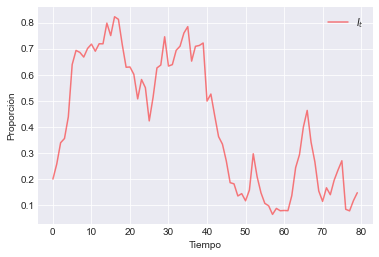

In [9]:
# Plotting the Euler-Maruyama process
plt.plot(x_t, "r", label=r"$I_t$", alpha=0.5)
plt.xlabel("Tiempo")
plt.legend()
plt.ylabel("Proporción")

In [10]:
# ODEs model
def SISS(i, theta):
    di = (i*(theta[0]-theta[1]*i)) 
    sigma1 =  theta[2] *( i-i**2)
    return di, sigma1

In [11]:
simga_2_ep = sum(np.diff(x_t)**2)/(Dt*sum((x_t**2)*(1-x_t)**2))
simga_ep=np.sqrt(simga_2_ep)
simga_ep

0.7699516033061777

In [12]:
# Define pymc model and sampling the MC Markov chain
nb_chains = 2 #choose >1 to run some convergence diagnostics on the chains
len_chains = 15000
len_burning_states = 5000

with pm.Model() as model:
    theta_m = [0,0,0]
    theta_m[0] = pm.Normal("beta-(mu+gamma)",0,1) 
    theta_m[1] = pm.Weibull("beta",5,1) 
    theta_m[2] = pm.HalfNormal("sigma",1)
    eu = EulerMaruyama("EM", Dt, SISS, (theta_m,),shape=x_t.shape, observed=x_t)

In [13]:
theta_t

array([0.46 , 0.8  , 0.842])

In [14]:
with model:
    trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains, start={"beta-(mu+gamma)":0.2,"beta":0.6,"sigma":simga_ep})
    data = az.from_pymc3(trace=trace)

C:\Users\sebas\AppData\Local\Temp\ipykernel_4600\2590649134.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(len_chains, tune=len_burning_states, cores=1, chains=nb_chains, start={"beta-(mu+gamma)":0.2,"beta":0.6,"sigma":simga_ep})
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, beta-(mu+gamma)]


Sampling 2 chains for 5_000 tune and 15_000 draw iterations (10_000 + 30_000 draws total) took 28 seconds.


WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl


There were 206 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6084624135814471, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [15]:
a=az.summary(trace)
a

Got error No model on context stack. trying to find log_likelihood in translation.
c:\Users\sebas\anaconda3\envs\pymc_env\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta-(mu+gamma),0.511,0.142,0.244,0.777,0.002,0.001,6802.0,6905.0,1.0
beta,0.884,0.192,0.511,1.229,0.002,0.002,7160.0,8408.0,1.0
sigma,0.797,0.066,0.680,0.924,0.001,0.001,7397.0,6605.0,1.0


In [16]:
theta_t

array([0.46 , 0.8  , 0.842])

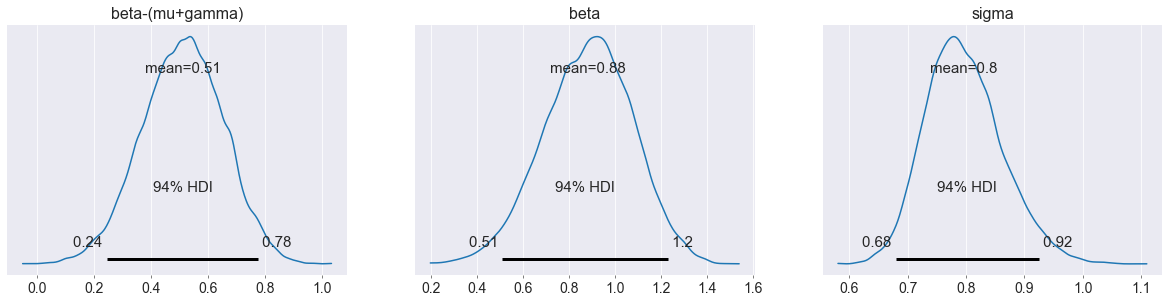

In [17]:
# Plot posterior densities
az.plot_posterior(data, 
                  var_names=["beta-(mu+gamma)", "beta","sigma"]);
plt.show()

Text(0, 0.5, 'MCMC promedio')

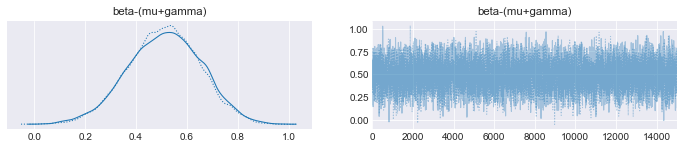

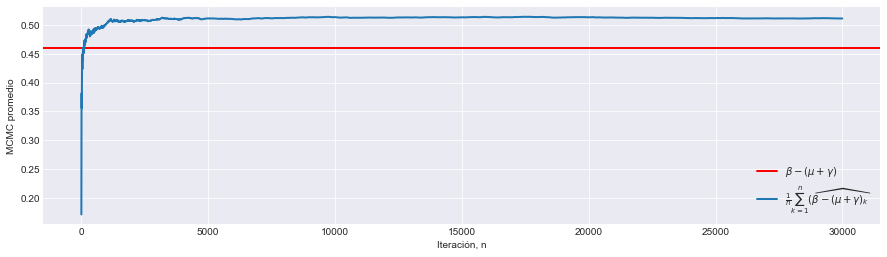

In [18]:
# plot the exploration for each chain and convergence of the ergodic mean
# beta - (mu+gamma)
az.plot_trace({"beta-(mu+gamma)": trace.get_values(varname="beta-(mu+gamma)", combine=False)})
mean_theta0 = [np.mean(trace['beta-(mu+gamma)'][:i]) for i in np.arange(1, len(trace['beta-(mu+gamma)']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[0]], lw=2, color="red", label=r"$\beta-(\mu+\gamma)$")
plt.plot(mean_theta0, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{(\beta-(\mu+\gamma)}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

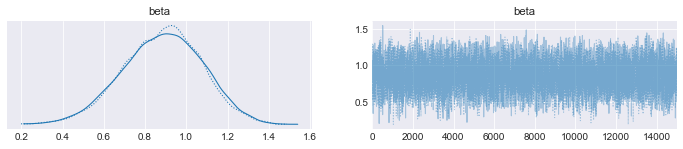

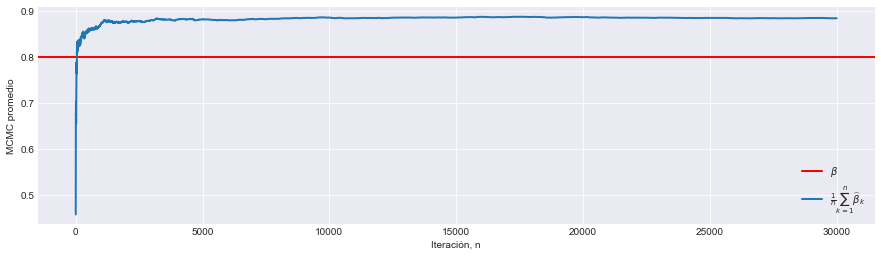

In [19]:
# beta
az.plot_trace({"beta": trace.get_values(varname="beta", combine=False)})
mean_theta1 = [np.mean(trace['beta'][:i]) for i in np.arange(1, len(trace['beta']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[1]], lw=2, color="red", label=r"$\beta$")
plt.plot(mean_theta1, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\beta}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

Text(0, 0.5, 'MCMC promedio')

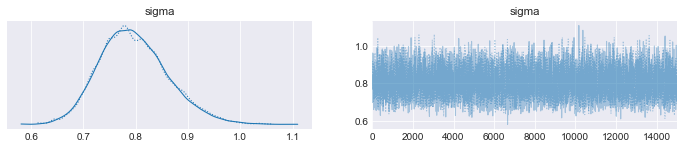

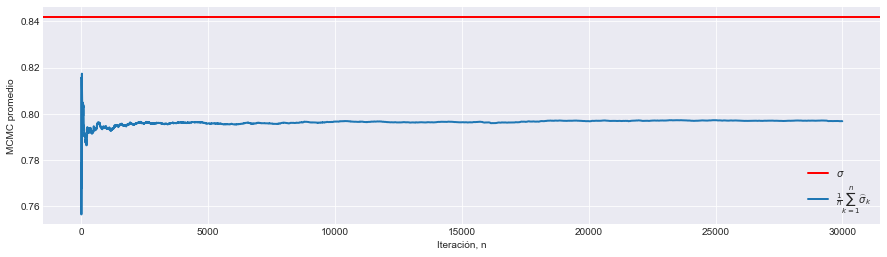

In [20]:
# sigma
az.plot_trace({"sigma": trace.get_values(varname="sigma", combine=False)})
mean_theta2 = [np.mean(trace['sigma'][:i]) for i in np.arange(1, len(trace['sigma']))]
plt.figure(figsize=(15, 4))
plt.axhline([theta_t[2]], lw=2, color="red", label=r"$\sigma$")
plt.plot(mean_theta2, lw=2, label=r"$\frac{1}{n}\sum_{k=1}^n\widehat{\sigma}_k$")
plt.xlabel("Iteración, n")
plt.legend()
plt.ylabel("MCMC promedio")

In [21]:
theta_est = [mean_theta0[-1],mean_theta1[-1],mean_theta2[-1]]

R_0 = 1+(theta_est[0]-0.5*theta_est[2]**2)/(theta_est[1]-theta_est[0])
R_0


1.5183930628382525

In [22]:
if R_0 > 1:
    print('la enfermedad persiste')
else: 
    if theta_est[2]**2 <= theta_est[1]:
        print('la enfermedad se extingue')

la enfermedad persiste


In [23]:
if theta_est[2]**2 > theta_est[1]*max(1,(0.5*theta_est[1])/(theta_est[1]-theta_est[0])):
    print('la enfermedad se extingue')

In [24]:
theta

array([0.46 , 0.8  , 0.842])

In [25]:
theta_est

[0.5110556630950118, 0.8844740670951099, 0.7968414559060404]

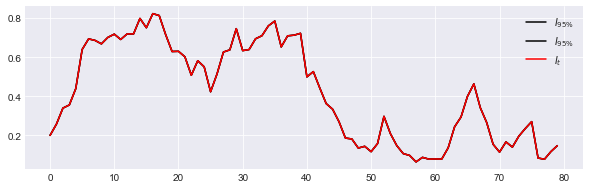

In [26]:
# generate trace from posterior
ppc_trace = pm.sample_posterior_predictive(trace, model=model)

# plot with data
plt.figure(figsize=(10, 3))
plt.plot(np.percentile(ppc_trace["EM"], [2.5, 97.5], axis=0).T, "k", label=r"$I_{95\%}$")
plt.plot(x_t, "r", label=r"$I_t$")
plt.legend()

$MSE_S=\mathbb{E}\left [ \sum_{i=0}^{N}\left| M_s(w)(\hat{\theta_0},\hat{\theta_1},\hat{\theta_2})-I_{obs}(t_i)\right|^2 \right ]$

$MSE_S \approx \frac{1}{mc}\left [ \sum_{j=1}^{mc}\sum_{i=0}^{N}\left| M_s(wj)-I_{obs}(t_i)\right|^2 \right ]$

In [27]:
def trayectorias(infected_obs,theta_est):
    Dt = 1 # time step
    N = len(infected_obs)-1
    i0 = infected_obs[0]
    x = i0 # initial proportion of infected 
    x_t_est = []

    # simulate
    for i in range(N):
        x = x + (x*(theta_est[0]-(x*theta_est[1])))*Dt + theta_est[2] * (x-x**2) * np.random.normal()*np.sqrt(Dt)
        x_t_est.append(x)
    x_t_est = np.array(x_t_est) # convert the values into an array
    x_t_est=np.insert(x_t_est,0,i0,axis=0) # add the initial condition at the beginning of the array
    return  np.abs(x_t_est)

Text(0.5, 1.0, 'Validacion SISS Mayor, Trayectoria 1 \n error cuadratico medio: 0.11595121190366522')

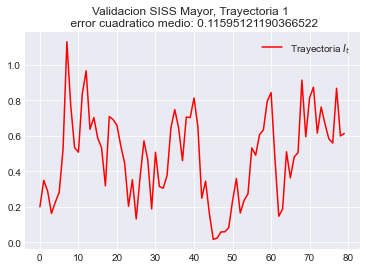

In [31]:
aa=trayectorias(x_t,theta_est)
msr_aa=mean_squared_error(x_t,aa)
plt.plot(trayectorias(x_t,theta_est), "r", label=r"Trayectoria $I_t$")
plt.legend()
plt.title("Validacion SISS Mayor, Trayectoria 1 \n error cuadratico medio: "+ str(msr_aa))

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 08 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

numpy     : 1.22.3
matplotlib: 3.5.1
scipy     : 1.7.3
plotly    : 5.10.0
sys       : 3.10.4 | packaged by conda-forge | (main, Mar 30 2022, 08:38:02) [MSC v.1916 64 bit (AMD64)]
pandas    : 1.4.3
arviz     : 0.12.1
theano    : 1.1.2
pymc3     : 3.11.4

Watermark: 2.3.1

